In [5]:
import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [6]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/02_Station_result_csv'
phase = 'SKS'
# MAG = 6
notplotLIST = ['TRLG','BRNG','GUDG']

SAVEpath = '/Volumes/home/Research/STEP/05_Station_result_statistics'

In [7]:
def Calc_rho(RCdt, SCdt):
    rho = RCdt/SCdt 
    return rho
def Calc_Phi(RCPhi, SCPhi):
    Phi = max (abs(RCPhi-SCPhi), abs(SCPhi-RCPhi))
    if Phi > 90: Phi = 180 - Phi
    return Phi


pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region):
#     grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
##==========legned setting 
    figmap.plot(x=40.5,y=39.1,style="c0.5c", pen="black", no_clip=True)
    figmap.text(x=40.5,y=38.9,text='Null', font="12p,Times-Bold,black", no_clip=True)
    RCdata = [[41.5, 39.1, 0, 5, 1*40]]
    SCdata = [[41.5, 38.9, 0, 5, 1*40]]
    figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=39.1,text='RC', font="12p,Times-Bold,black", no_clip=True)
    figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=38.9,text='SC', font="12p,Times-Bold,black", no_clip=True)
    legenddata=[[43, 39.1, 0, 5, 0.5*40],[43.8, 39.1, 0, 5, 1*40],[44.8, 39.1, 0, 5, 1.5*40]]
    figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
    figmap.text(x=43,y=38.9,text='0.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=43.8,y=38.9,text='1s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=44.8,y=38.9,text='1.5s', font="12p,Times-Bold,black", no_clip=True)
    with pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman', FONT_LABEL = '13p,Times-Roman',
                      MAP_ANNOT_OFFSET_PRIMARY = '0.15c',
                      MAP_LABEL_OFFSET = '0.2c', 
                      MAP_TICK_LENGTH_PRIMARY = '0.1c',
                      MAP_FRAME_PEN = '1.5p'):
        figmap.colorbar(cmap = 'cmapBAZ.cpt', position = 'x0.8/1.2+w5c/0.3c+mh+h',
                        frame=["a90", "x+lBack-azimuth" ])#frame = ["a90",'+L"Back azimuth"'])
        
def Plot_event(figmap, nullEvent, nonnullEvent):
    figmap.shift_origin(xshift = '10c', yshift = '9c')
    lat = 42; lon = 44
    colfill = '217.6/217.6/217.6'
    figmap.coast(region='g', 
              projection = f'E{lon}/{lat}/180/8c', 
              resolution = 'c', 
              land = colfill, 
              shorelines ='1/0.1p,' + colfill, 
              C = colfill, 
              frame = True)

    figmap.plot(x = lon, y = lat, style ='s0.6c', pen ='0.2', color = 'red')

    distlims = [60,90,120,150]
    for dists in distlims:
        figmap.plot(x = lon, y = lat, style ='E-' + str(2 * dists) + 'd', 
                 pen ='1p,black,3_1:0p',t = '60')
    figmap.text(x = 44, y = -20,  text = f'60@.', font='9p')
    figmap.text(x = 44, y = -48,  text = '90@.', font='9p')
    figmap.text(x = 44, y = -79,  text = '120@.', font='9p')
    figmap.text(x = -137, y = -71,   text = '150@.', font='9p')
    if len(nullEvent['Lon']) >0:
        figmap.plot(x=nullEvent['Lon'],y= nullEvent['Lat'],
            color=nullEvent['Dep'],cmap = 'cmapEQs.cpt' , style='c0.3c' ,pen="1p,black",transparency=50)
    if len(nonnullEvent['Lon']) >0:
        figmap.plot(x=nonnullEvent['Lon'],y= nonnullEvent['Lat'],
            color=nonnullEvent['Dep'],cmap = 'cmapEQs.cpt' , style='a0.6c' ,pen="1p,black")
    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '15p,Times-Roman',
                      MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                      MAP_LABEL_OFFSET = '0.8c', 
                      MAP_TICK_LENGTH_PRIMARY = '0.3c',
                      MAP_FRAME_PEN = '1.5p'):    
        figmap.colorbar(cmap = 'cmapEQs.cpt', position = 'x9.5/0.55+w7c/0.4c+ml',
                        frame=["a100f50", "+LDepth(km)" ])   

II.KIV
/Volumes/home/Research/STEP/02_Station_result_csv/2010-2015_Mw6+7_85-100degree/II.KIV_split_result_mw67_85-100.csv
/Volumes/home/Research/STEP/02_Station_result_csv/2010-2015_Mw7_100-140degree/II.KIV_split_result_mw7.csv
/Volumes/home/Research/STEP/02_Station_result_csv/2010-2015_Mw6_100-140degree/II.KIV_split_result_mw6.csv


coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/1) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 224 degrees.


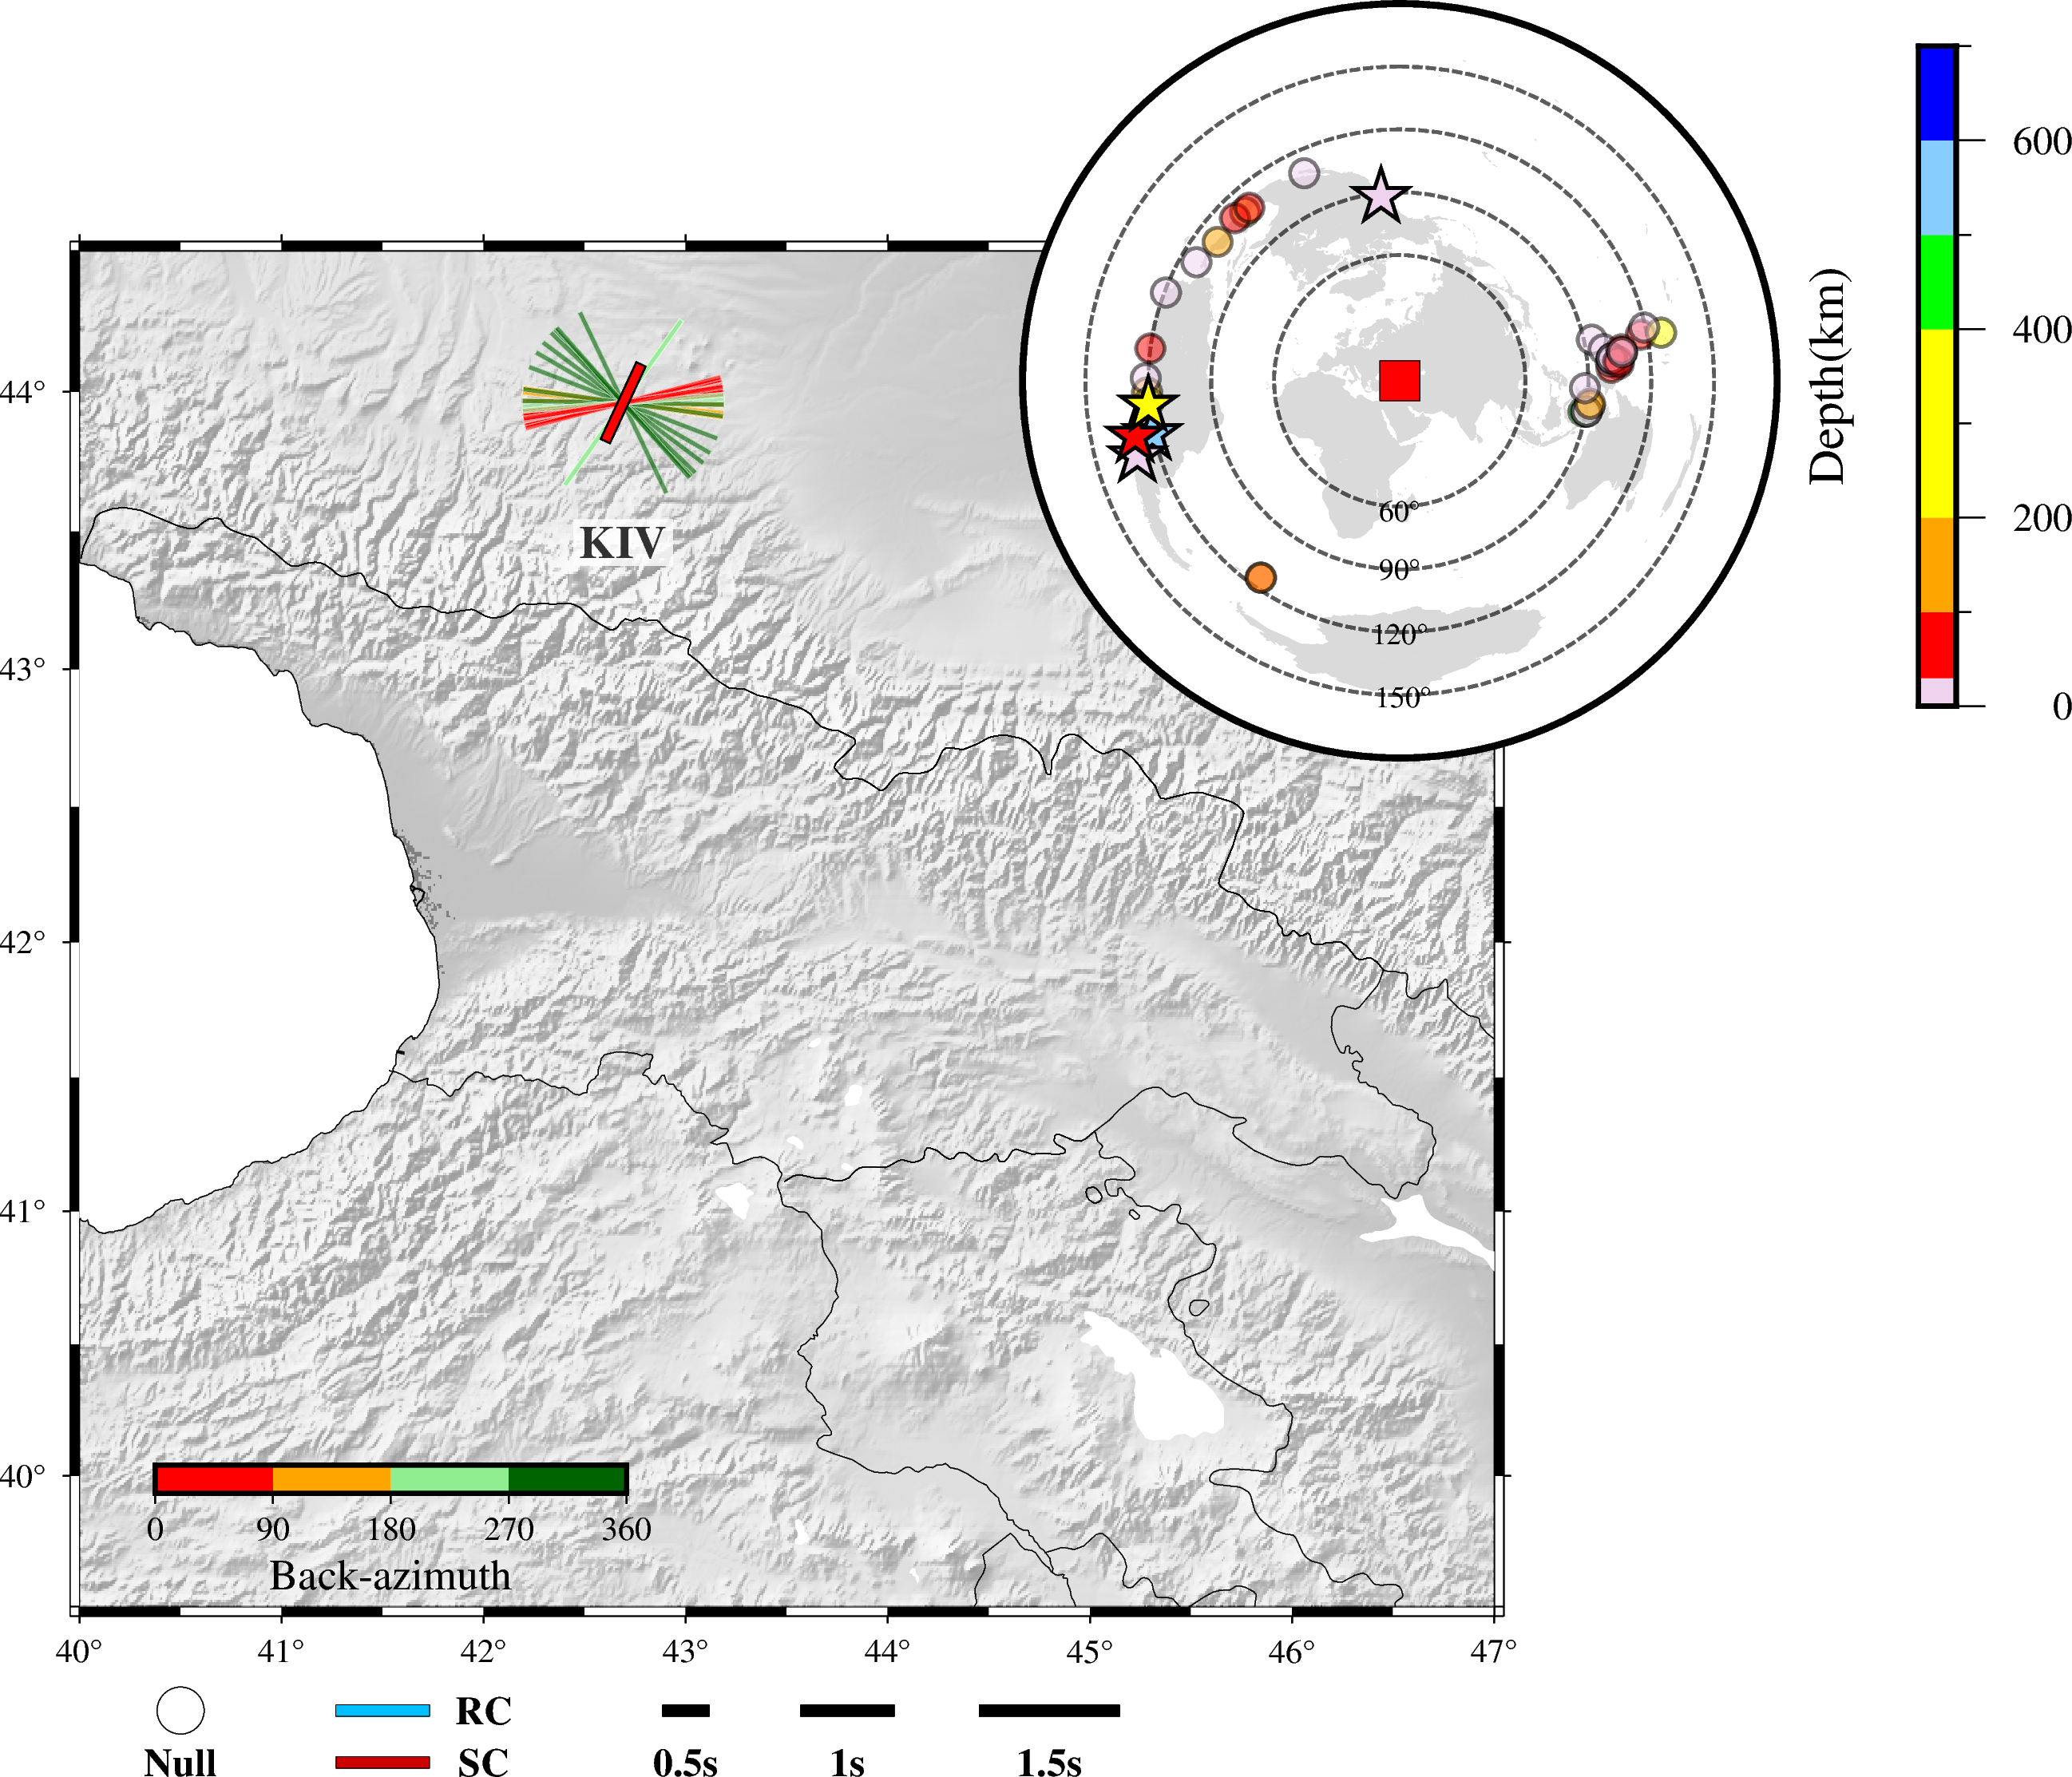

In [20]:

regvals = [40, 47, 39.5, 44.5]

meandf = pd.read_csv(f'/Volumes/home/Research/STEP/05_Station_result_statistics/Station_SKS_2010-2015average.csv')

for STApath in glob.glob(f'{PKLpath}/II*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    print(f'{NET}.{STA}')  
    
    figmap = pygmt.Figure()
    PygmtBegin(figmap, regvals)
    nonnullEvent = {'Lat':[],'Lon':[],'Dep':[]}
    nullEvent = {'Lat':[],'Lon':[],'Dep':[],'CpH':[]}
    
    stlat = values['latitude']; stlon = values['longitude']
    mean   = meandf[meandf['Station']== f'{NET}.{STA}']
    meanSCPhi = mean['SCphi'].values[0]
    meanSCdt = mean['SCdt'].values[0]
    
    for csvpath in glob.glob(f'{Path}/2010*/{NET}*{STA}*.csv'):
        print(csvpath)
        df = pd.read_csv(csvpath)
        df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']<7]
    
        
        for i in range(len(df)):
            evlat = df['Ev_lat'].values[i]
            evlon = df['Ev_lon'].values[i]
            depth = df['Depth'].values[i]
            RCPhi = df['RCPhi'].values[i]
            RCdt  = df['RCdt'].values[i]
            SCPhi = df['SCPhi'].values[i]
            SCdt  = df['SCdt'].values[i]

            rho = Calc_rho(RCdt, SCdt)
            phi = Calc_Phi(RCPhi, SCPhi)
            
            dist, az, baz = gps2dist_azimuth(evlat,evlon,stlat,stlon)
            if 30 < phi < 68 or df["CpH"].values[i] > 0.76 :
                if df["CpH"].values[i] >= 0.9:
                    SCdata = [[stlon, stlat, baz-90, 2, 2*40]]
                    if 0<=baz<90: color='red'
                    elif 90<=baz<180: color='orange'
                    elif 180<=baz<270: color='lightgreen'
                    elif 270<=baz<360: color='darkgreen'
                    figmap.plot(data=SCdata, style="J", color=color, pen="0.01p,white",transparency=40)
                    nullEvent['Lat'].append(evlat)
                    nullEvent['Lon'].append(evlon)
                    nullEvent['Dep'].append(depth)                
                    nullEvent['CpH'].append(df["CpH"].values[i]) 
            elif 0.8 < rho < 1.1 and phi < 8:## non-null good condition 
                nonnullEvent['Lat'].append(evlat)
                nonnullEvent['Lon'].append(evlon)
                nonnullEvent['Dep'].append(depth)
            elif 0.7 <= rho < 1.2 and phi <= 25: ## non-null FAIR condition 
                nonnullEvent['Lat'].append(evlat)
                nonnullEvent['Lon'].append(evlon)
                nonnullEvent['Dep'].append(depth)
            else: pass
    if np.isnan(meanSCPhi) == False:
        SCdata = [[stlon, stlat, meanSCPhi-90, 4, meanSCdt*40]]
        figmap.plot(data=SCdata, style="J", color="red1", pen="0.5p,black")
    else: 
        figmap.plot(x=stlon, y=stlat, style="c0.2c",color='black', pen="white")
    if stlat < 41: yadjust = +0.5
    else: yadjust = -0.5
    figmap.text(x=stlon,y=stlat+yadjust,text=STA, font="14p,Times-Bold,black",fill='white',transparency=20)
    
    Plot_event(figmap, nullEvent, nonnullEvent)         
    figmap.show()
#     figmap.savefig(f'{SAVEpath}/{NET}.{STA}/{NET}.{STA}_2010-2015_CatalogPlotonMap.png')
#     figmap.savefig(f'{SAVEpath}/{NET}.{STA}/{NET}.{STA}_2010-2015_CatalogPlotonMap.pdf')

